In [1]:
!pip3 show gensim

Name: gensim
Version: 3.6.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /home/fox/.local/lib/python3.10/site-packages
Requires: numpy, scipy, six, smart-open
Required-by: 


In [2]:
from datetime import datetime
import os
import wget
import numpy as np
from zipfile import *
from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import FastText
import gzip
from ipynb.fs.defs.functions_and_classes import *

In [3]:
#model = 'word2vec'
model = 'glove'
#model = 'fasttext'
dim = 300
#language = 'he'
language = 'en'
#suffix_pair = ['ity', 'ness']
suffix_pair = ['al', 'less']
suff1, suff2 = suffix_pair

# Loading

In [4]:
"""def build_dict_from_model(model, vocab):
    #For processing Word2Vec .model files. The .npy files are also needed. Works with gensim 3.6
    embedding = defaultdict()
    for word in list(vocab):
        embedding[word] = model[word]
    display_embedding_properties(embedding)
    return embedding"""

'def build_dict_from_model(model, vocab):\n    #For processing Word2Vec .model files. The .npy files are also needed. Works with gensim 3.6\n    embedding = defaultdict()\n    for word in list(vocab):\n        embedding[word] = model[word]\n    display_embedding_properties(embedding)\n    return embedding'

In [5]:
inp = f'{model}_{dim}_{language}_vectors.txt'
header = False
print(f'Input: {inp}')

if model == 'fasttext' and language == 'he' and dim == 300:
    # we have to load a pretrained model
    if inp not in os.listdir('./models/raws/'):
        URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.he.vec'
        response = wget.download(URL, f'./models/raws/fasttext_{dim}_{language}_vectors.txt')
    header = True
if model == 'glove' and language == 'en' and dim == 300:
    if f'glove_{dim}_{language}_vectors.txt' not in os.listdir('./models/raws/'):
    # We'll have to regenerate the model
        if 'glove.42B.300d.zip' not in os.listdir('./models/raws/'):
        # We'll have to re-download the model
            URL = "https://nlp.stanford.edu/data/glove.42B.300d.zip"
            response = wget.download(URL, './models/raws/glove.42B.300d.zip')
        with ZipFile('./models/raws/glove.42B.300d.zip', 'r') as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall(f'./models/raws/')
            #!wget https://nlp.stanford.edu/data/glove.42B.300d.zip
            #!unzip glove.42B.300d.zip
        os.rename('./models/raws/glove.42B.300d.txt', f'./models/raws/glove_{dim}_{language}_vectors.txt')
        #os.remove('./models/raws/glove.42B.300d.zip')

# The fasttext model has less entries in the .vec format for some reason???

embedding = build_dict_from_vector_file('./models/raws/', inp, header)

Input: glove_300_en_vectors.txt
Processed 0
Processed 50000
Processed 100000
Processed 150000
Processed 200000
Processed 250000
Processed 300000
Processed 350000
Processed 400000
Processed 450000
Processed 500000
Processed 550000
Processed 600000
Processed 650000
Processed 700000
Processed 750000
Processed 800000
Processed 850000
Processed 900000
Processed 950000
Processed 1000000
Processed 1050000
Processed 1100000
Processed 1150000
Processed 1200000
Processed 1250000
Processed 1300000
Processed 1350000
Processed 1400000
Processed 1450000
Processed 1500000
Processed 1550000
Processed 1600000
Processed 1650000
Processed 1700000
Processed 1750000
Processed 1800000
Processed 1850000
Processed 1900000
Embedding entries: 1917494
Embedding dimension: 300


# Dataset adjustment

In [6]:
"""with open('./hebrew dataset/definitive_dataset.csv' ,'w') as f:
    f.write('Noun,Denominal(s),Non-denominal(s),Other(s)\n')
    for dp in dataset:
        n = dp['noun']
        dns = dp['denom']
        dns = [dn for dn in dns if dn != '']
        dns = ' '.join(dns)
        ndns = dp['non_denom']
        ndns = [ndn for ndn in ndns if ndn != '']
        ndns = ' '.join(ndns)
        others = dp['others']
        others = [other for other in others if other != '']
        others = ' '.join(others)
        print(dns)
        print(ndns)
        print(others)
        f.write(f'{n},{dns},{ndns},{others}\n')"""

"with open('./hebrew dataset/definitive_dataset.csv' ,'w') as f:\n    f.write('Noun,Denominal(s),Non-denominal(s),Other(s)\n')\n    for dp in dataset:\n        n = dp['noun']\n        dns = dp['denom']\n        dns = [dn for dn in dns if dn != '']\n        dns = ' '.join(dns)\n        ndns = dp['non_denom']\n        ndns = [ndn for ndn in ndns if ndn != '']\n        ndns = ' '.join(ndns)\n        others = dp['others']\n        others = [other for other in others if other != '']\n        others = ' '.join(others)\n        print(dns)\n        print(ndns)\n        print(others)\n        f.write(f'{n},{dns},{ndns},{others}\n')"

In [7]:
if language == 'he':
    path_to_dataset = './datasets/he/definitive_dataset.csv'
if language == 'en':
    path_to_dataset = f'./datasets/en/{suff1}_{suff2}_dataset_filtered.csv'

dataset = load_dataset_from_csv(language, path_to_dataset)

In [8]:
dataset.display_content()

Datapoint #1:
Base (noun or adjective): accent
L1-affixed (-ity or -al): accentual
L2-affixed (-ness or -less): accentless
Datapoint #2:
Base (noun or adjective): action
L1-affixed (-ity or -al): actional
L2-affixed (-ness or -less): actionless
Datapoint #3:
Base (noun or adjective): anther
L1-affixed (-ity or -al): antheral
L2-affixed (-ness or -less): antherless
Datapoint #4:
Base (noun or adjective): author
L1-affixed (-ity or -al): authorial
L2-affixed (-ness or -less): authorless
Datapoint #5:
Base (noun or adjective): barb
L1-affixed (-ity or -al): barbal
L2-affixed (-ness or -less): barbless
Datapoint #6:
Base (noun or adjective): benefice
L1-affixed (-ity or -al): beneficial
L2-affixed (-ness or -less): beneficeless
Datapoint #7:
Base (noun or adjective): bract
L1-affixed (-ity or -al): bracteal
L2-affixed (-ness or -less): bractless
Datapoint #8:
Base (noun or adjective): bride
L1-affixed (-ity or -al): bridal
L2-affixed (-ness or -less): brideless
Datapoint #9:
Base (noun or 

In [9]:
dataset.filter_against_embedding(embedding)

Number of datapoints before adjustment: 205
Number of datapoints after adjustment: 59


In [10]:
dataset.datapoints

In [11]:
triplets = dataset.get_triplets()

en
['accent', 'accentual', 'accentless']
en
en
['action', 'actional', 'actionless']
en
en
['author', 'authorial', 'authorless']
en
en
['bride', 'bridal', 'brideless']
en
en
['case', 'casual', 'caseless']
en
en
['cause', 'causal', 'causeless']
en
en
['cement', 'cemental', 'cementless']
en
en
['center', 'central', 'centerless']
en
en
['client', 'cliental', 'clientless']
en
en
['crust', 'crustal', 'crustless']
en
en
['dimension', 'dimensional', 'dimensionless']
en
en
['direction', 'directional', 'directionless']
en
en
['disk', 'discal', 'diskless']
en
en
['distortion', 'distortional', 'distortionless']
en
en
['duration', 'durational', 'durationless']
en
en
['emotion', 'emotional', 'emotionless']
en
en
['event', 'eventual', 'eventless']
en
en
['exception', 'exceptional', 'exceptionless']
en
en
['expression', 'expressional', 'expressionless']
en
en
['face', 'facial', 'faceless']
en
en
['feature', 'featural', 'featureless']
en
en
['form', 'formal', 'formless']
en
en
['foundation', 'foundatio

In [12]:
lexicon = dataset.get_lexicon()

In [13]:
vecs = dataset.get_vecs(embedding)

In [14]:
len(triplets)

59

# Reduction

In [19]:
"""def get_target_dim(vecs):
    cov_matrix = np.cov(vecs.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    #similarly sort the eigenvectors 
    sorted_eigenvectors = eigenvectors[:,sorted_index]
    target_dim = len([ev for ev in eigenvalues if ev >= 1])
    eigenvector_subset = sorted_eigenvectors[:,0:target_dim]
    print(eigenvector_subset.shape)
    #vecs_reduced = np.dot(eigenvector_subset.transpose(),X_meaned.transpose()).transpose()
    print(vecs.shape)
    return target_dim, np.dot(vecs, eigenvector_subset)"""
    


Initial dimension: 300
Final dimension: 96
Explained variance: 0.9005606804376343


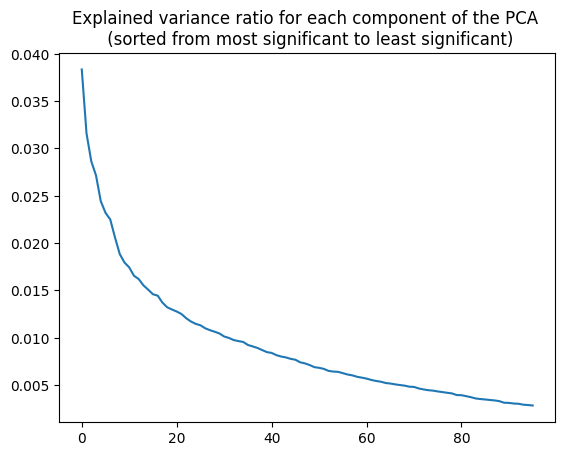

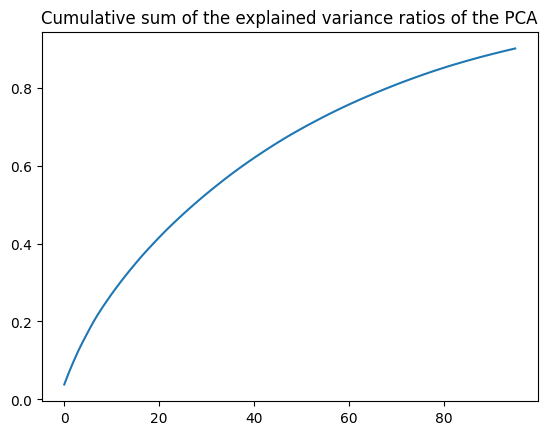

In [20]:
reduced_embedding = reduce_dim(lexicon, vecs)

# Save

In [21]:
def write_dict_to_vector_file(embedding):
    fname = f'{model}_{dim}_{language}_vectors_reduced.txt'
    with open(f'./models/reduced/{fname}', 'w') as f:
        for w, v in embedding.items():
            l = f'{w} '
            for x in v:
                l = l+f'{str(x)} '
            l = l[:-1]+'\n'
            f.write(l)

In [22]:
write_dict_to_vector_file(reduced_embedding)